## API guide code


Import the requisite packages, and make our matplotlib figures display in the notebook. 

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Demonstrate the basic operation of the API. 

In [14]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Bitfinex"
f = requests.get(url)
ipdata = f.json()
# As we see from the documentation at https://min-api.cryptocompare.com/, the 'Data' 
# field contains the information we are interested in. 
pd.DataFrame(ipdata['Data']).head(5)

,close,high,low,open,time,volumefrom,volumeto
0,6707.0,6789.0,6557.00,6732.9,1535241600,15595.78,1.041933e+08
1,6909.4,6940.8,6652.70,6707.0,1535328000,22800.47,1.540135e+08
2,7079.9,7127.9,6872.00,6909.4,1535414400,28175.44,1.972351e+08
3,7039.0,7139.4,6924.27,7079.9,1535500800,19818.37,1.396372e+08
4,6986.0,7060.0,6802.10,7039.0,1535587200,22854.28,1.580074e+08


### Historical price data

We turn the above code into a function to let us query historical BTC price data. This provides the prototype for querying any of the APIs - just change the URL and input arguments accordingly. 

In [220]:
def get_data(date):
    """ Query the API for 2000 days historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

There is a 2000 data point per query limit. When querying the historical price data we also need to make sure that the period requested is returned despite the limit. We can do this by repeatedly querying the API until data from the requested date is returned. 

In [221]:
def get_df(from_date, to_date):
    """ Get historical price data between two dates. """
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    # and adding the results to a list. 
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=False, inplace=True)        
    return df

Now we can make a DataFrame which contains all of the historical price data by calling our function. We use UNIX time input here. 

In [222]:
df = get_df(1504435200, 1534435200)

Finally we can plot the data. We plot the high, low and close price for each day - and its clear that at the peak there were some massive daily price changes!

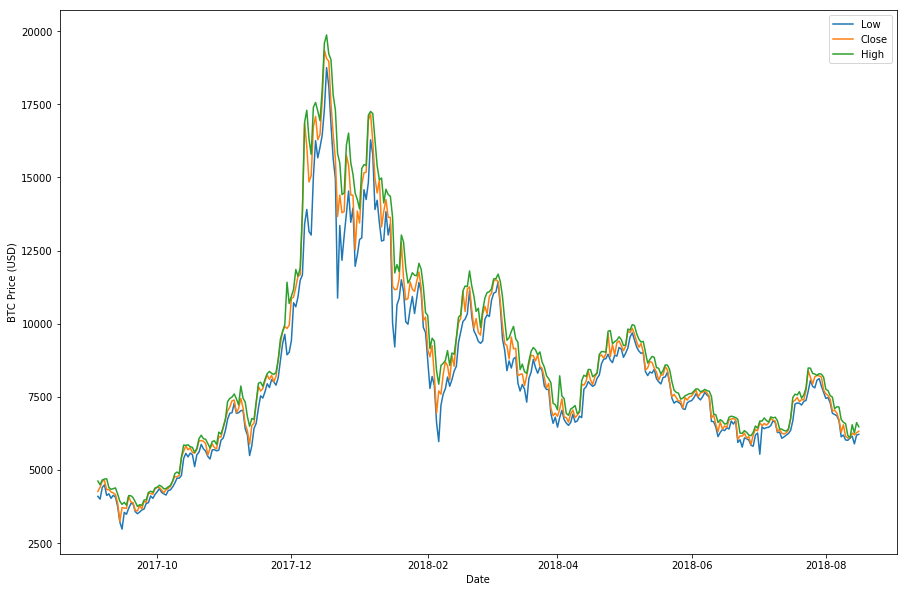

In [223]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df[['low', 'close', 'high']])
ax.set_ylabel('BTC Price (USD)')
ax.set_xlabel('Date')
ax.legend(['Low', 'Close', 'High']);

### Diversifying your investment

Now we look at something using more API data. Here we explore what coins you might like to invest in if you wanted to diversify your crypto portfolio, and wanted coins whose price was not correlated. 

We need to update our functions a little bit first - we now want to be able to specify which coin to get data for. While we're at it, we'll also allow the function to choose whether to query daily or hourly data, which we'll use later. 

In [15]:
def get_data_spec(coin, date, time_period):
    """ Query the API for 2000 units historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/{}?fsym={}&tsym=USD&limit=2000&toTs={}".format(time_period, coin, date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

For the purposes of this demonstration, we will also only be interested in the close price, so we will only return that. 

In [16]:
def get_df_spec(time_period, coin, from_date, to_date):
    """ Get historical price data between two dates. If further apart than query limit then query multiple times. """
    date = to_date
    holder = []
    while date > from_date:
        # Now we use the new function to query specific coins
        data = get_data_spec(coin, date, time_period) 
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom'] 
    df = pd.concat(holder, axis = 0)
    df = df[df['time']>from_date]
    df['time'] = pd.to_datetime(df['time'], unit='s') 
    df.set_index('time', inplace=True)
    df.sort_index(ascending=False, inplace=True)
    # And just keep the close price, with the column heading as the name of the coin. 
    df.rename(columns={'close':coin}, inplace=True)
    return df[coin]

Now lets write a script to get all of the data that we're interested in. We choose 5 coins, making sure to include Tether which we expect to be fairly uncorrelated as a test. The dates that we will get data between are from the New Year to today. 

In [17]:
# These are the coins that we will compare. 
coins = ['BTC', 'ETH', 'DOGE', 'USDT', 'DASH']

In [18]:
holder = []
from_date = 1514764800 # 2018 New Year
to_date = 1536081800   # Today
time_period = 'histoday'
for coin in coins:
    holder.append(get_df_spec(time_period, coin, from_date, to_date))
df = pd.concat(holder, axis = 1)

Now lets calculate a metric that won't allow intradependence to give misleading correlation scores - we will use rate of return. 

In [19]:
# Convert each of the columns of the DataFrame to be rate of return instead of price. 
df = df.divide(df.shift())-1

We can now visualise the correlations between the coins. We can use matplotlib to do this, but here we favour importing seaborn instead because it means we have to do a little less work on annotating the plot. Feel free to try out the matplotlib version to see the difference. 

In [20]:
# This works, but it's more effort to label. 
# plt.matshow(df.corr())

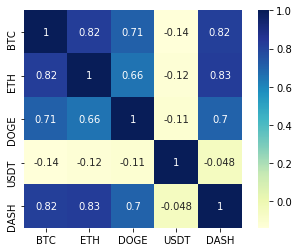

In [21]:
# This is easy to label. 
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", square = True);

In the time period considered above there was a large peak in the price of all cryptocoins - the one we saw in our original investigation for Bitcoin. Is it still valid for, say, this week when there were less extreme price variations? Let's use hourly data here so we have more data points. 

In [10]:
holder = []
from_date = 1535480760  # Last week
to_date = 1536081800    # Today
time_period = 'histohour'
for coin in coins:
    holder.append(get_df_spec(time_period, coin, from_date, to_date))
df = pd.concat(holder, axis = 1)

In [11]:
df = df.divide(df.shift())-1

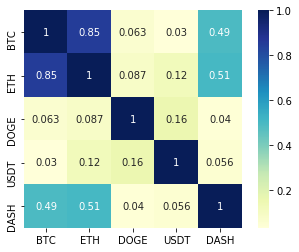

In [13]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", square = True);

Thanks for following along, that's all for this tutorial. Stay tuned for updates on some interesting projects we've been working on!